# Fever classifier (Typhoid) — End-to-end notebook
**Filename:** `fever_classifier_typhoid_notebook.ipynb`  
**Author / Team:** Ayushmitra (Pushkar Kumar & team)  
**Purpose:** Train and evaluate a Typhoid (acute) classifier using the processed clinical dataset from Bangladesh.  
This notebook covers: EDA → preprocessing → train/validation/test split → model training (Logistic Regression, Random Forest, Keras NN) → evaluation → save artifacts to Google Drive → provide a prediction API snippet for chatbot integration.  

**Notes:**
- We assume you placed `Processed Dataset.csv` inside:
  `/content/drive/MyDrive/Ayushmitra_Models/fever_classifier_typhoid/Processed Dataset.csv`
- All artifacts (model files, scaler, feature list) will be saved to the same Drive folder.
- Use this as the canonical pipeline for reproducible model creation and later integration into the chatbot backend.


In [1]:
# Mount Google Drive first (Colab)
from google.colab import drive
drive.mount('/content/drive')

# Set a project folder path (change if your folder name/path differs)
DRIVE_MODEL_DIR = "/content/drive/MyDrive/SIH_2025/Ayushmitra_Models/fever_classifier_typhoid"
print("Model / data folder:", DRIVE_MODEL_DIR)

# List files in folder to confirm
import os
if not os.path.exists(DRIVE_MODEL_DIR):
    print(f"Folder not found: {DRIVE_MODEL_DIR}. Creating it.")
    os.makedirs(DRIVE_MODEL_DIR)
    print(f"Folder created: {DRIVE_MODEL_DIR}")

print("Files in folder:")
print(os.listdir(DRIVE_MODEL_DIR))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model / data folder: /content/drive/MyDrive/SIH_2025/Ayushmitra_Models/fever_classifier_typhoid
Files in folder:
['fever_classifier_typhoid_notebook.ipynb', 'Original Dataset.csv', 'Validation Certificate.pdf', 'Processed Dataset.csv', 'TyphoDx-BD A Clinically Validated Dataset for Mach.zip']


## Install dependencies and import libraries
We will install required Python packages (if not already present) and import them.
- `tensorflow` for Keras neural network
- `scikit-learn` for classic ML and metrics
- `joblib` for saving scalers/encoders
- `matplotlib` / `seaborn` for plots


In [2]:
# (Uncomment if needed) Install packages in Colab (skip if already available)
!pip install -q tensorflow scikit-learn joblib seaborn matplotlib

# Imports
import pandas as pd
import numpy as np
import os, json, joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set plotting style
sns.set(style="whitegrid")


## Load processed dataset
We will load `Processed Dataset.csv` from the Drive folder.  
This processed file is expected to be cleaned and ready for modelling (no missing values).


In [3]:
# Path to processed dataset
DATA_CSV = os.path.join(DRIVE_MODEL_DIR, "Processed Dataset.csv")

# Read CSV
df = pd.read_csv(DATA_CSV)
print("Dataset shape:", df.shape)
display(df.head())


Dataset shape: (1100, 16)


,Age,Gender,TO,TH,AH,BH,OX2,OXK,OX9,A,M,Rickettsia_Suspect,Acute_typhoid,Paratyphoid_A,Paratyphoid_B,Typhoid
0,5y,Male,"""1:80""","""1:80""","""1:80""","""1:80""","""1:320""","""1:320""","""1:80""","""1:80""","""1:80""",Yes,No,No,No,Negative
1,3.5y,Male,"""1:160""","""1:80""","""1:80""","""1:80""","""1:80""","""1:80""","""1:80""","""1:80""","""1:80""",No,Yes,No,No,Minimal
2,45y,Male,"""1:80""","""1:80""","""1:80""","""1:80""","""1:160""","""1:160""","""1:80""","""1:80""","""1:80""",Yes,No,No,No,Negative
3,13y,Female,"""1:80""","""1:160""","""1:80""","""1:80""","""1:160""","""1:320""","""1:80""","""1:80""","""1:160""",Yes,No,No,No,Minimal
4,12y,Female,"""1:160""","""1:320""","""1:80""","""1:80""","""1:160""","""1:160""","""1:320""","""1:80""","""1:80""",Yes,Yes,No,No,Positive


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('Age').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('Gender').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_3.groupby('TO').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('TH').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Age')):
  _plot_series(series, series_name, i)
  fig.legend(title='Age', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Gender')):
  _plot_series(series, series_name, i)
  fig.legend(title='Gender', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('TO')):
  _plot_series(series, series_name, i)
  fig.legend(title='TO', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('TH')):
  _plot_series(series, series_name, i)
  fig.legend(title='TH', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_9['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['Gender'].value_counts()
    for x_label, grp in _df_10.groupby('Age')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Age')
_ = plt.ylabel('Gender')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['TO'].value_counts()
    for x_label, grp in _df_11.groupby('Gender')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('Gender')
_ = plt.ylabel('TO')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['TH'].value_counts()
    for x_label, grp in _df_12.groupby('TO')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('TO')
_ = plt.ylabel('TH')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['OX2'].value_counts()
    for x_label, grp in _df_13.groupby('TH')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('TH')
_ = plt.ylabel('OX2')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_14['Age'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_14, x='index', y='Age', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_15['Gender'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_15, x='index', y='Gender', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['TO'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x='index', y='TO', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['TH'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='index', y='TH', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

## Quick EDA (Exploratory Data Analysis)
We will:
- Inspect columns and datatypes
- Check target distribution
- Show basic statistics for numeric columns (titers)
- Plot distributions for key serology markers


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 1100 non-null   object
 1   Gender              1100 non-null   object
 2   TO                  1100 non-null   object
 3   TH                  1100 non-null   object
 4   AH                  1100 non-null   object
 5   BH                  1100 non-null   object
 6   OX2                 1100 non-null   object
 7   OXK                 1100 non-null   object
 8   OX9                 1100 non-null   object
 9   A                   1100 non-null   object
 10  M                   1100 non-null   object
 11  Rickettsia_Suspect  1100 non-null   object
 12  Acute_typhoid       1100 non-null   object
 13  Paratyphoid_A       1100 non-null   object
 14  Paratyphoid_B       1100 non-null   object
 15  Typhoid             1100 non-null   object
dtypes: object(16)
memory usa

None

Columns: ['Age', 'Gender', 'TO', 'TH', 'AH', 'BH', 'OX2', 'OXK', 'OX9', 'A', 'M', 'Rickettsia_Suspect', 'Acute_typhoid ', 'Paratyphoid_A ', 'Paratyphoid_B', 'Typhoid']

Acute_typhoid  value counts:
Acute_typhoid 
No     784
Yes    316
Name: count, dtype: int64

Typhoid value counts:
Typhoid
Minimal     560
Negative    462
Positive     78
Name: count, dtype: int64

Paratyphoid_A  value counts:
Paratyphoid_A 
No     1019
Yes      81
Name: count, dtype: int64

Paratyphoid_B value counts:
Paratyphoid_B
No     1075
Yes      25
Name: count, dtype: int64

Rickettsia_Suspect value counts:
Rickettsia_Suspect
No     821
Yes    279
Name: count, dtype: int64

Numeric columns: ['Age', 'TO', 'TH', 'AH', 'BH', 'OX2', 'OXK', 'OX9', 'A', 'M']


,Age,TO,TH,AH,BH,OX2,OXK,OX9,A,M
count,1039.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.000000,1100.0,1100.000000
mean,31.422714,103.563636,111.490909,91.709091,81.963636,102.618182,103.418182,87.418182,80.0,81.890909
std,21.711732,38.351264,52.458701,46.882686,13.722803,58.270959,56.683818,32.604108,0.0,12.158601
min,1.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.0,80.000000
25%,12.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.0,80.000000
50%,27.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.0,80.000000
75%,50.000000,160.000000,160.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.0,80.000000
max,90.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,80.0,160.000000


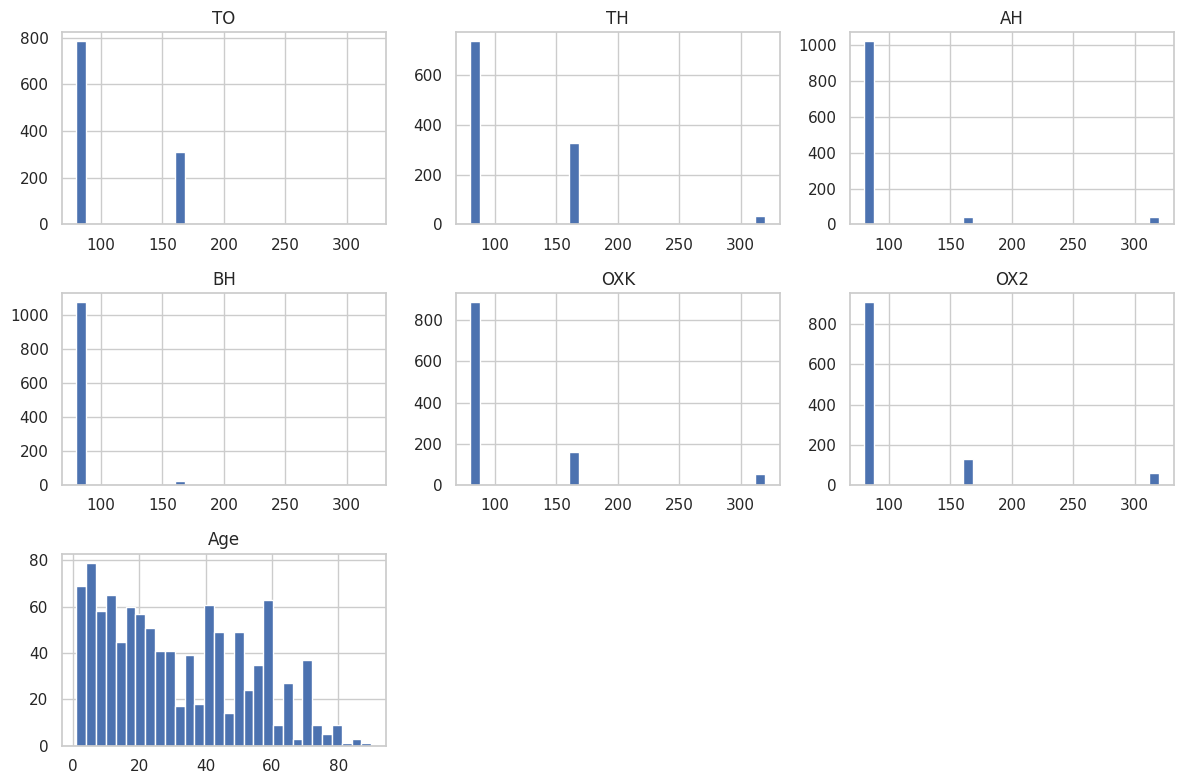

In [5]:
# Columns & dtypes
display(df.info())

# Check columns
print("Columns:", df.columns.tolist())

# Convert serology and age columns to numeric, coercing errors
numeric_cols_to_convert = ["TO", "TH", "AH", "BH", "OX2", "OXK", "OX9", "A", "M"]
for col in numeric_cols_to_convert:
    if col in df.columns:
        # Remove quotes and convert to numeric, handling potential ratios like "1:80"
        # This assumes the format is "value1:value2" and we want the second value
        # Or just a single number in quotes
        df[col] = df[col].astype(str).str.replace('"', '', regex=False)
        df[col] = df[col].apply(lambda x: int(x.split(':')[-1]) if ':' in x else pd.to_numeric(x, errors='coerce'))

# Convert Age to numeric, handling units like 'y'
if 'Age' in df.columns:
    df['Age'] = df['Age'].astype(str).str.replace('y', '', regex=False)
    df['Age'] = pd.to_numeric(df['Age'], errors='coerce')


# Check unique values for possible target columns
for col in ["Acute_typhoid ", "Typhoid", "Paratyphoid_A ", "Paratyphoid_B", "Rickettsia_Suspect"]:
    if col in df.columns:
        print(f"\n{col} value counts:")
        print(df[col].value_counts(dropna=False))

# Summary statistics for numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric columns:", numeric_cols)
display(df[numeric_cols].describe())

# Plot histograms for key serological markers (if present)
markers = [c for c in ["TO", "TH", "AH", "BH", "OXK", "OX2", "OX19", "Age"] if c in numeric_cols] # Use numeric_cols here
if markers:
    df[markers].hist(bins=30, figsize=(12,8))
    plt.tight_layout()
    plt.show() # Added plt.show() to display the plot

## Decide prediction task
For the first model we'll predict **`Acute_typhoid` (Yes/No)** as a binary classification task.
If your dataset uses 'Yes'/'No' or 'Yes/No' strings, we'll map them to 1/0.


In [7]:
# Choose target column - change if different in your dataset
TARGET_COL = "Acute_typhoid "   # expects 'Yes'/'No' or 1/0

# Verify column exists
if TARGET_COL not in df.columns:
    raise KeyError(f"Target column '{TARGET_COL}' not found in dataset columns: {df.columns.tolist()}")

# Map target to binary 0/1 if necessary
y_raw = df[TARGET_COL].copy()
if y_raw.dtype == object or y_raw.dtype == 'category':
    # Common cases: 'Yes'/'No', 'Positive'/'Negative', '1'/'0'
    mapping = {}
    unique_vals = sorted(y_raw.dropna().unique())
    print("Unique target values:", unique_vals)
    # Heuristics for mapping
    if set([str(x).lower() for x in unique_vals]).issubset(set(["yes","no"])):
        mapping = {"Yes":1, "No":0, "YES":1, "NO":0, "yes":1, "no":0}
    elif set([str(x).lower() for x in unique_vals]).issubset(set(["positive","negative"])):
        mapping = {"Positive":1, "Negative":0, "positive":1, "negative":0}
    elif set([str(x) for x in unique_vals]).issubset(set(["0","1"])):
        # Already strings '0'/'1'
        mapping = {"1":1, "0":0}
    else:
        # Last resort: map first seen as positive
        mapping = {val: (1 if i==0 else 0) for i,val in enumerate(unique_vals)}
        print("Fallback mapping used:", mapping)
    # Apply mapping
    y = y_raw.map(mapping).astype(int)
else:
    # Numeric already expected
    y = y_raw.astype(int)

print("Target distribution:\n", y.value_counts(normalize=True), "\nCounts:\n", y.value_counts())

Unique target values: ['No', 'Yes']
Target distribution:
 Acute_typhoid 
0    0.712727
1    0.287273
Name: proportion, dtype: float64 
Counts:
 Acute_typhoid 
0    784
1    316
Name: count, dtype: int64


## Feature selection & preprocessing plan
- Use serological test markers (TO, TH, AH, BH, OXK, OX2, OX19) and Age, Gender (if available).
- Convert Gender to binary (Male=0, Female=1) if present.
- Use one-hot encoding only where needed; for the current dataset markers should be numeric.
- Train/val/test split: 70% train, 15% validation, 15% test (stratified on target).
- Standardize numeric features using `StandardScaler` fitted on the training set.


In [8]:
# Select features (include only columns present)
candidate_features = ["TO","TH","AH","BH","OXK","OX2","OX19","Age","Gender","M","A"]
features = [c for c in candidate_features if c in df.columns]
print("Selected features:", features)

# Prepare X
X = df[features].copy()

# Map Gender if present
if "Gender" in X.columns:
    # Map common values to 0/1
    X["Gender"] = X["Gender"].map(lambda v: 1 if str(v).strip().lower() in ["female","f","woman"] else 0)

# Fill any rare NaNs conservatively (processed CSV likely has none)
X = X.fillna(0)

# Save feature list for later
feature_list = X.columns.tolist()
print("Final feature list:", feature_list)


Selected features: ['TO', 'TH', 'AH', 'BH', 'OXK', 'OX2', 'Age', 'Gender', 'M', 'A']
Final feature list: ['TO', 'TH', 'AH', 'BH', 'OXK', 'OX2', 'Age', 'Gender', 'M', 'A']


## Train / Validation / Test split
We split data into:
- Train: 70%
- Validation: 15%
- Test: 15%

We stratify by the target so class balance is preserved.


In [9]:
# First split: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

# Second split: validation (15%), test (15%) from temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Sizes -> Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Save scaler for later (to Drive)
scaler_path = os.path.join(DRIVE_MODEL_DIR, "scaler.pkl")
joblib.dump(scaler, scaler_path)
print("Saved scaler to:", scaler_path)


Sizes -> Train: (770, 10) Val: (165, 10) Test: (165, 10)
Saved scaler to: /content/drive/MyDrive/SIH_2025/Ayushmitra_Models/fever_classifier_typhoid/scaler.pkl


## Baseline model: Logistic Regression
Train a simple logistic regression for baseline performance. Evaluate on the validation set.


In [10]:
# Train logistic regression
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_scaled, y_train)

# Validate
y_val_pred = lr.predict(X_val_scaled)
y_val_proba = lr.predict_proba(X_val_scaled)[:,1]

print("Validation classification report (Logistic Regression):\n")
print(classification_report(y_val, y_val_pred))

# Save model
lr_path = os.path.join(DRIVE_MODEL_DIR, "logreg_typhoid.pkl")
joblib.dump(lr, lr_path)
print("Saved logistic regression model to:", lr_path)


Validation classification report (Logistic Regression):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       117
           1       1.00      1.00      1.00        48

    accuracy                           1.00       165
   macro avg       1.00      1.00      1.00       165
weighted avg       1.00      1.00      1.00       165

Saved logistic regression model to: /content/drive/MyDrive/SIH_2025/Ayushmitra_Models/fever_classifier_typhoid/logreg_typhoid.pkl


## Ensemble baseline: Random Forest
Train a RandomForestClassifier and inspect feature importances. Often performs well out-of-the-box.


In [11]:
rf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced')
rf.fit(X_train_scaled, y_train)

# Validation
y_val_pred_rf = rf.predict(X_val_scaled)
print("Validation classification report (Random Forest):\n")
print(classification_report(y_val, y_val_pred_rf))

# Feature importances
importances = rf.feature_importances_
feat_imp = pd.Series(importances, index=feature_list).sort_values(ascending=False)
print("\nFeature importances:\n", feat_imp)

# Save RF model
rf_path = os.path.join(DRIVE_MODEL_DIR, "rf_typhoid.pkl")
joblib.dump(rf, rf_path)
print("Saved random forest to:", rf_path)


Validation classification report (Random Forest):

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       117
           1       1.00      1.00      1.00        48

    accuracy                           1.00       165
   macro avg       1.00      1.00      1.00       165
weighted avg       1.00      1.00      1.00       165


Feature importances:
 TO        0.932265
TH        0.023086
Age       0.014859
AH        0.012352
OXK       0.006521
OX2       0.004898
Gender    0.003007
BH        0.002166
M         0.000844
A         0.000000
dtype: float64
Saved random forest to: /content/drive/MyDrive/SIH_2025/Ayushmitra_Models/fever_classifier_typhoid/rf_typhoid.pkl


## Neural network (Keras) model
A small dense neural network that may capture nonlinear interactions. We will use EarlyStopping and save the best model.


In [12]:
# Build model
tf.random.set_seed(42)
model_version = "v1"

nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
model_file = os.path.join(DRIVE_MODEL_DIR, f"nn_typhoid_{model_version}.h5")
es = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
mc = ModelCheckpoint(model_file, monitor='val_loss', save_best_only=True)

# Train
history = nn.fit(X_train_scaled, y_train, validation_data=(X_val_scaled, y_val),
                 epochs=100, batch_size=32, callbacks=[es, mc], verbose=2)

print("Best model saved to:", model_file)


Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


25/25 - 4s - 157ms/step - accuracy: 0.7571 - loss: 0.5568 - val_accuracy: 0.8364 - val_loss: 0.4393
Epoch 2/100


25/25 - 1s - 24ms/step - accuracy: 0.9026 - loss: 0.3672 - val_accuracy: 0.9636 - val_loss: 0.2675
Epoch 3/100


25/25 - 1s - 27ms/step - accuracy: 0.9662 - loss: 0.2230 - val_accuracy: 0.9818 - val_loss: 0.1379
Epoch 4/100


25/25 - 1s - 22ms/step - accuracy: 0.9896 - loss: 0.1167 - val_accuracy: 1.0000 - val_loss: 0.0629
Epoch 5/100


25/25 - 1s - 20ms/step - accuracy: 0.9974 - loss: 0.0603 - val_accuracy: 1.0000 - val_loss: 0.0301
Epoch 6/100


25/25 - 1s - 35ms/step - accuracy: 0.9974 - loss: 0.0360 - val_accuracy: 1.0000 - val_loss: 0.0175
Epoch 7/100


25/25 - 1s - 55ms/step - accuracy: 0.9987 - loss: 0.0258 - val_accuracy: 1.0000 - val_loss: 0.0100
Epoch 8/100


25/25 - 1s - 29ms/step - accuracy: 0.9948 - loss: 0.0176 - val_accuracy: 1.0000 - val_loss: 0.0070
Epoch 9/100


25/25 - 1s - 36ms/step - accuracy: 0.9974 - loss: 0.0162 - val_accuracy: 1.0000 - val_loss: 0.0046
Epoch 10/100


25/25 - 0s - 10ms/step - accuracy: 0.9987 - loss: 0.0144 - val_accuracy: 1.0000 - val_loss: 0.0031
Epoch 11/100


25/25 - 0s - 9ms/step - accuracy: 0.9974 - loss: 0.0119 - val_accuracy: 1.0000 - val_loss: 0.0024
Epoch 12/100


25/25 - 0s - 12ms/step - accuracy: 0.9987 - loss: 0.0090 - val_accuracy: 1.0000 - val_loss: 0.0020
Epoch 13/100


25/25 - 0s - 11ms/step - accuracy: 0.9974 - loss: 0.0087 - val_accuracy: 1.0000 - val_loss: 0.0017
Epoch 14/100


25/25 - 0s - 9ms/step - accuracy: 0.9987 - loss: 0.0051 - val_accuracy: 1.0000 - val_loss: 0.0013
Epoch 15/100


25/25 - 0s - 10ms/step - accuracy: 1.0000 - loss: 0.0047 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 16/100


25/25 - 0s - 8ms/step - accuracy: 0.9987 - loss: 0.0060 - val_accuracy: 1.0000 - val_loss: 8.6920e-04
Epoch 17/100


25/25 - 0s - 13ms/step - accuracy: 1.0000 - loss: 0.0035 - val_accuracy: 1.0000 - val_loss: 7.3663e-04
Epoch 18/100


25/25 - 0s - 9ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 6.2037e-04
Epoch 19/100
25/25 - 0s - 9ms/step - accuracy: 0.9987 - loss: 0.0036 - val_accuracy: 1.0000 - val_loss: 7.1666e-04
Epoch 20/100


25/25 - 0s - 14ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 5.1367e-04
Epoch 21/100


25/25 - 0s - 11ms/step - accuracy: 1.0000 - loss: 0.0021 - val_accuracy: 1.0000 - val_loss: 3.9615e-04
Epoch 22/100


25/25 - 0s - 8ms/step - accuracy: 1.0000 - loss: 0.0031 - val_accuracy: 1.0000 - val_loss: 3.1526e-04
Epoch 23/100


25/25 - 0s - 11ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 1.0000 - val_loss: 2.6646e-04
Epoch 24/100


25/25 - 0s - 8ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 2.3116e-04
Epoch 25/100


25/25 - 0s - 12ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 2.0482e-04
Epoch 26/100
25/25 - 0s - 11ms/step - accuracy: 0.9987 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 2.0815e-04
Epoch 27/100


25/25 - 0s - 7ms/step - accuracy: 0.9987 - loss: 0.0027 - val_accuracy: 1.0000 - val_loss: 1.6395e-04
Epoch 28/100


25/25 - 0s - 12ms/step - accuracy: 1.0000 - loss: 9.5289e-04 - val_accuracy: 1.0000 - val_loss: 1.4771e-04
Epoch 29/100


25/25 - 0s - 8ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 1.0000 - val_loss: 1.4464e-04
Epoch 30/100


25/25 - 0s - 8ms/step - accuracy: 1.0000 - loss: 6.7773e-04 - val_accuracy: 1.0000 - val_loss: 1.3643e-04
Epoch 31/100


25/25 - 0s - 10ms/step - accuracy: 1.0000 - loss: 9.5333e-04 - val_accuracy: 1.0000 - val_loss: 1.1996e-04
Epoch 32/100


25/25 - 0s - 8ms/step - accuracy: 1.0000 - loss: 6.8810e-04 - val_accuracy: 1.0000 - val_loss: 1.0896e-04
Epoch 33/100


25/25 - 0s - 8ms/step - accuracy: 1.0000 - loss: 7.8230e-04 - val_accuracy: 1.0000 - val_loss: 9.8039e-05
Epoch 34/100


25/25 - 0s - 8ms/step - accuracy: 1.0000 - loss: 7.4134e-04 - val_accuracy: 1.0000 - val_loss: 8.9102e-05
Epoch 35/100


25/25 - 0s - 8ms/step - accuracy: 1.0000 - loss: 7.8855e-04 - val_accuracy: 1.0000 - val_loss: 8.6165e-05
Epoch 36/100


25/25 - 0s - 7ms/step - accuracy: 1.0000 - loss: 5.2704e-04 - val_accuracy: 1.0000 - val_loss: 7.8919e-05
Epoch 37/100


25/25 - 0s - 8ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 1.0000 - val_loss: 6.8066e-05
Epoch 38/100


25/25 - 0s - 9ms/step - accuracy: 0.9987 - loss: 0.0020 - val_accuracy: 1.0000 - val_loss: 6.0976e-05
Epoch 39/100


25/25 - 0s - 7ms/step - accuracy: 1.0000 - loss: 8.1464e-04 - val_accuracy: 1.0000 - val_loss: 5.7734e-05
Epoch 40/100


25/25 - 0s - 13ms/step - accuracy: 1.0000 - loss: 4.7771e-04 - val_accuracy: 1.0000 - val_loss: 5.3642e-05
Epoch 41/100


25/25 - 0s - 9ms/step - accuracy: 1.0000 - loss: 5.0514e-04 - val_accuracy: 1.0000 - val_loss: 5.0057e-05
Epoch 42/100


25/25 - 0s - 12ms/step - accuracy: 1.0000 - loss: 4.1739e-04 - val_accuracy: 1.0000 - val_loss: 4.6596e-05
Epoch 43/100


25/25 - 0s - 13ms/step - accuracy: 1.0000 - loss: 4.9346e-04 - val_accuracy: 1.0000 - val_loss: 4.3666e-05
Epoch 44/100


25/25 - 1s - 24ms/step - accuracy: 1.0000 - loss: 2.9980e-04 - val_accuracy: 1.0000 - val_loss: 4.1058e-05
Epoch 45/100


25/25 - 0s - 12ms/step - accuracy: 1.0000 - loss: 4.1256e-04 - val_accuracy: 1.0000 - val_loss: 3.8315e-05
Epoch 46/100


25/25 - 1s - 25ms/step - accuracy: 1.0000 - loss: 2.5275e-04 - val_accuracy: 1.0000 - val_loss: 3.6250e-05
Epoch 47/100
25/25 - 1s - 22ms/step - accuracy: 0.9987 - loss: 0.0023 - val_accuracy: 1.0000 - val_loss: 3.8963e-05
Epoch 48/100
25/25 - 0s - 14ms/step - accuracy: 1.0000 - loss: 3.7194e-04 - val_accuracy: 1.0000 - val_loss: 5.1360e-05
Epoch 49/100


25/25 - 1s - 26ms/step - accuracy: 0.9987 - loss: 0.0028 - val_accuracy: 1.0000 - val_loss: 3.3598e-05
Epoch 50/100


25/25 - 0s - 18ms/step - accuracy: 1.0000 - loss: 4.3972e-04 - val_accuracy: 1.0000 - val_loss: 3.1759e-05
Epoch 51/100


25/25 - 0s - 18ms/step - accuracy: 0.9987 - loss: 0.0026 - val_accuracy: 1.0000 - val_loss: 2.6548e-05
Epoch 52/100


25/25 - 0s - 10ms/step - accuracy: 1.0000 - loss: 8.3287e-04 - val_accuracy: 1.0000 - val_loss: 2.4526e-05
Epoch 53/100


25/25 - 0s - 10ms/step - accuracy: 0.9987 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 2.3045e-05
Epoch 54/100


25/25 - 0s - 14ms/step - accuracy: 1.0000 - loss: 3.5788e-04 - val_accuracy: 1.0000 - val_loss: 2.2641e-05
Epoch 55/100


25/25 - 0s - 12ms/step - accuracy: 1.0000 - loss: 2.8997e-04 - val_accuracy: 1.0000 - val_loss: 2.1077e-05
Epoch 56/100


25/25 - 0s - 13ms/step - accuracy: 0.9987 - loss: 0.0017 - val_accuracy: 1.0000 - val_loss: 1.8846e-05
Epoch 57/100


25/25 - 1s - 20ms/step - accuracy: 1.0000 - loss: 1.5606e-04 - val_accuracy: 1.0000 - val_loss: 1.8513e-05
Epoch 58/100


25/25 - 0s - 12ms/step - accuracy: 1.0000 - loss: 2.2908e-04 - val_accuracy: 1.0000 - val_loss: 1.7822e-05
Epoch 59/100


25/25 - 0s - 12ms/step - accuracy: 1.0000 - loss: 5.6863e-04 - val_accuracy: 1.0000 - val_loss: 1.7792e-05
Epoch 60/100


25/25 - 0s - 7ms/step - accuracy: 1.0000 - loss: 2.5163e-04 - val_accuracy: 1.0000 - val_loss: 1.6930e-05
Epoch 61/100


25/25 - 0s - 13ms/step - accuracy: 1.0000 - loss: 1.3908e-04 - val_accuracy: 1.0000 - val_loss: 1.6433e-05
Epoch 62/100


25/25 - 0s - 13ms/step - accuracy: 1.0000 - loss: 1.2728e-04 - val_accuracy: 1.0000 - val_loss: 1.6081e-05
Epoch 63/100
25/25 - 0s - 10ms/step - accuracy: 0.9987 - loss: 0.0015 - val_accuracy: 1.0000 - val_loss: 2.2133e-05
Epoch 64/100
25/25 - 0s - 12ms/step - accuracy: 1.0000 - loss: 3.5096e-04 - val_accuracy: 1.0000 - val_loss: 2.3010e-05
Epoch 65/100
25/25 - 0s - 6ms/step - accuracy: 1.0000 - loss: 2.3795e-04 - val_accuracy: 1.0000 - val_loss: 1.9816e-05
Epoch 66/100
25/25 - 0s - 5ms/step - accuracy: 1.0000 - loss: 1.4957e-04 - val_accuracy: 1.0000 - val_loss: 1.6936e-05
Epoch 67/100


25/25 - 0s - 10ms/step - accuracy: 1.0000 - loss: 3.4645e-04 - val_accuracy: 1.0000 - val_loss: 1.3915e-05
Epoch 68/100


25/25 - 0s - 10ms/step - accuracy: 1.0000 - loss: 2.1561e-04 - val_accuracy: 1.0000 - val_loss: 1.1940e-05
Epoch 69/100


25/25 - 0s - 7ms/step - accuracy: 1.0000 - loss: 1.7038e-04 - val_accuracy: 1.0000 - val_loss: 1.0927e-05
Epoch 70/100


25/25 - 0s - 7ms/step - accuracy: 1.0000 - loss: 1.2028e-04 - val_accuracy: 1.0000 - val_loss: 1.0434e-05
Epoch 71/100


25/25 - 0s - 12ms/step - accuracy: 1.0000 - loss: 8.6739e-05 - val_accuracy: 1.0000 - val_loss: 1.0131e-05
Epoch 72/100


25/25 - 0s - 12ms/step - accuracy: 1.0000 - loss: 1.6845e-04 - val_accuracy: 1.0000 - val_loss: 9.7810e-06
Epoch 73/100


25/25 - 0s - 7ms/step - accuracy: 0.9987 - loss: 0.0061 - val_accuracy: 1.0000 - val_loss: 9.3004e-06
Epoch 74/100


25/25 - 0s - 7ms/step - accuracy: 1.0000 - loss: 1.8343e-04 - val_accuracy: 1.0000 - val_loss: 9.1855e-06
Epoch 75/100


25/25 - 0s - 7ms/step - accuracy: 1.0000 - loss: 1.7149e-04 - val_accuracy: 1.0000 - val_loss: 8.6386e-06
Epoch 76/100


25/25 - 0s - 13ms/step - accuracy: 1.0000 - loss: 1.1166e-04 - val_accuracy: 1.0000 - val_loss: 8.2984e-06
Epoch 77/100


25/25 - 0s - 11ms/step - accuracy: 1.0000 - loss: 7.2789e-05 - val_accuracy: 1.0000 - val_loss: 8.0660e-06
Epoch 78/100


25/25 - 0s - 7ms/step - accuracy: 1.0000 - loss: 1.8256e-04 - val_accuracy: 1.0000 - val_loss: 7.6103e-06
Epoch 79/100


25/25 - 0s - 9ms/step - accuracy: 1.0000 - loss: 9.3965e-05 - val_accuracy: 1.0000 - val_loss: 7.3205e-06
Epoch 80/100


25/25 - 0s - 7ms/step - accuracy: 1.0000 - loss: 1.7349e-04 - val_accuracy: 1.0000 - val_loss: 7.0090e-06
Epoch 81/100


25/25 - 0s - 12ms/step - accuracy: 1.0000 - loss: 2.3619e-04 - val_accuracy: 1.0000 - val_loss: 6.4890e-06
Epoch 82/100


25/25 - 0s - 12ms/step - accuracy: 1.0000 - loss: 3.6288e-04 - val_accuracy: 1.0000 - val_loss: 6.4861e-06
Epoch 83/100
25/25 - 0s - 6ms/step - accuracy: 1.0000 - loss: 1.6705e-04 - val_accuracy: 1.0000 - val_loss: 6.5774e-06
Epoch 84/100


25/25 - 0s - 9ms/step - accuracy: 1.0000 - loss: 8.6804e-05 - val_accuracy: 1.0000 - val_loss: 6.2098e-06
Epoch 85/100


25/25 - 0s - 10ms/step - accuracy: 1.0000 - loss: 5.7711e-05 - val_accuracy: 1.0000 - val_loss: 6.0253e-06
Epoch 86/100


25/25 - 0s - 10ms/step - accuracy: 1.0000 - loss: 1.4365e-04 - val_accuracy: 1.0000 - val_loss: 5.8537e-06
Epoch 87/100


25/25 - 0s - 11ms/step - accuracy: 1.0000 - loss: 8.0933e-05 - val_accuracy: 1.0000 - val_loss: 5.6652e-06
Epoch 88/100


25/25 - 0s - 9ms/step - accuracy: 1.0000 - loss: 5.0895e-05 - val_accuracy: 1.0000 - val_loss: 5.5015e-06
Epoch 89/100


25/25 - 0s - 12ms/step - accuracy: 1.0000 - loss: 6.3228e-05 - val_accuracy: 1.0000 - val_loss: 5.3879e-06
Epoch 90/100


25/25 - 0s - 12ms/step - accuracy: 1.0000 - loss: 6.7651e-05 - val_accuracy: 1.0000 - val_loss: 5.2497e-06
Epoch 91/100


25/25 - 0s - 7ms/step - accuracy: 1.0000 - loss: 8.4711e-05 - val_accuracy: 1.0000 - val_loss: 5.0222e-06
Epoch 92/100


25/25 - 0s - 7ms/step - accuracy: 1.0000 - loss: 4.8810e-05 - val_accuracy: 1.0000 - val_loss: 4.8130e-06
Epoch 93/100


25/25 - 0s - 13ms/step - accuracy: 1.0000 - loss: 6.2874e-04 - val_accuracy: 1.0000 - val_loss: 4.1253e-06
Epoch 94/100


25/25 - 0s - 8ms/step - accuracy: 1.0000 - loss: 1.3755e-04 - val_accuracy: 1.0000 - val_loss: 3.8884e-06
Epoch 95/100


25/25 - 0s - 12ms/step - accuracy: 1.0000 - loss: 1.1584e-04 - val_accuracy: 1.0000 - val_loss: 3.7215e-06
Epoch 96/100


25/25 - 0s - 12ms/step - accuracy: 1.0000 - loss: 2.0140e-04 - val_accuracy: 1.0000 - val_loss: 3.4039e-06
Epoch 97/100


25/25 - 0s - 14ms/step - accuracy: 1.0000 - loss: 1.7680e-04 - val_accuracy: 1.0000 - val_loss: 3.2256e-06
Epoch 98/100


25/25 - 1s - 23ms/step - accuracy: 1.0000 - loss: 3.3664e-05 - val_accuracy: 1.0000 - val_loss: 3.1628e-06
Epoch 99/100


25/25 - 1s - 24ms/step - accuracy: 1.0000 - loss: 1.0859e-04 - val_accuracy: 1.0000 - val_loss: 3.0582e-06
Epoch 100/100


25/25 - 0s - 10ms/step - accuracy: 1.0000 - loss: 1.4876e-04 - val_accuracy: 1.0000 - val_loss: 2.9753e-06
Best model saved to: /content/drive/MyDrive/SIH_2025/Ayushmitra_Models/fever_classifier_typhoid/nn_typhoid_v1.h5


## Evaluate the selected models on the TEST set
We will evaluate logistic regression, random forest, and the saved best neural network on the reserved test set.


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
=== Logistic Regression ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
ROC AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       118
           1       1.00      1.00      1.00        47

    accuracy                           1.00       165
   macro avg       1.00      1.00      1.00       165
weighted avg       1.00      1.00      1.00       165



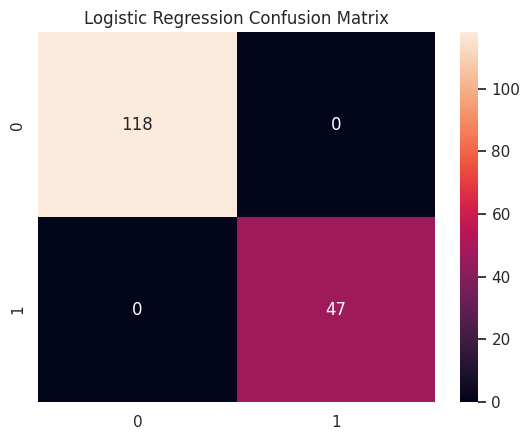

=== Random Forest ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
ROC AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       118
           1       1.00      1.00      1.00        47

    accuracy                           1.00       165
   macro avg       1.00      1.00      1.00       165
weighted avg       1.00      1.00      1.00       165



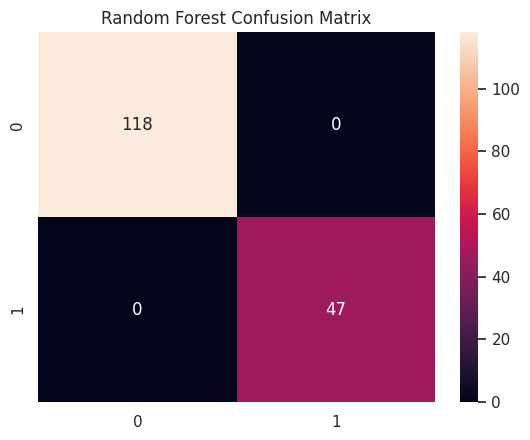

=== Neural Network ===
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
ROC AUC: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       118
           1       1.00      1.00      1.00        47

    accuracy                           1.00       165
   macro avg       1.00      1.00      1.00       165
weighted avg       1.00      1.00      1.00       165



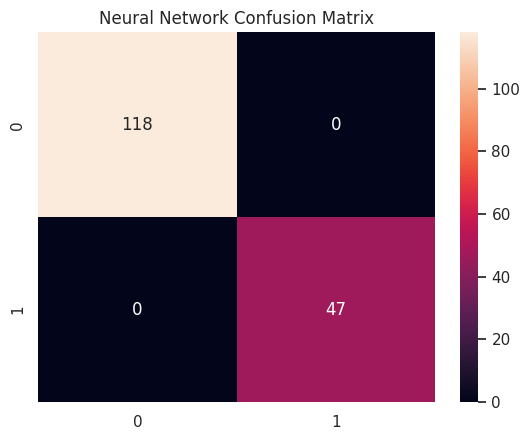

In [13]:
# Prepare test data (already scaled)
# Logistic Regression
y_test_pred_lr = lr.predict(X_test_scaled)
y_test_proba_lr = lr.predict_proba(X_test_scaled)[:,1]

# Random Forest
y_test_pred_rf = rf.predict(X_test_scaled)
y_test_proba_rf = rf.predict_proba(X_test_scaled)[:,1]

# Neural Net - load best model (if saved)
nn_loaded = tf.keras.models.load_model(model_file)
y_test_proba_nn = nn_loaded.predict(X_test_scaled).ravel()
y_test_pred_nn = (y_test_proba_nn >= 0.5).astype(int)

# Utility to print metrics
def print_metrics(y_true, y_pred, y_proba, model_name="Model"):
    print(f"=== {model_name} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, zero_division=0))
    print("Recall:", recall_score(y_true, y_pred, zero_division=0))
    print("F1:", f1_score(y_true, y_pred, zero_division=0))
    try:
        print("ROC AUC:", roc_auc_score(y_true, y_proba))
    except:
        print("ROC AUC: N/A")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d'); plt.title(model_name + " Confusion Matrix"); plt.show()

print_metrics(y_test, y_test_pred_lr, y_test_proba_lr, "Logistic Regression")
print_metrics(y_test, y_test_pred_rf, y_test_proba_rf, "Random Forest")
print_metrics(y_test, y_test_pred_nn, y_test_proba_nn, "Neural Network")


## Save model artifacts and metadata for integration
We will save:
- The final selected model (if NN chosen it's already saved)
- Scaler (saved earlier)
- Feature list JSON (order matters for inference)
- A small `metadata.json` describing model version and input format


In [14]:
# Save feature list
feat_file = os.path.join(DRIVE_MODEL_DIR, "feature_list.json")
with open(feat_file, "w") as f:
    json.dump(feature_list, f)
print("Saved feature list:", feat_file)

# Save metadata (model_version, target, features)
metadata = {
    "model_name": "typhoid_classifier",
    "model_version": model_version,
    "target": TARGET_COL,
    "features": feature_list
}
meta_file = os.path.join(DRIVE_MODEL_DIR, "metadata.json")
with open(meta_file, "w") as f:
    json.dump(metadata, f)
print("Saved metadata:", meta_file)


Saved feature list: /content/drive/MyDrive/SIH_2025/Ayushmitra_Models/fever_classifier_typhoid/feature_list.json
Saved metadata: /content/drive/MyDrive/SIH_2025/Ayushmitra_Models/fever_classifier_typhoid/metadata.json


## Prediction helper function
This function will be used by the chatbot backend. It:
- Accepts a dictionary of raw inputs (feature_name -> value)
- Builds a DataFrame in the correct feature order
- Applies the scaler and loaded model
- Returns probability + label + short human-friendly text
We will save this function here for local testing.


In [15]:
# Load artifacts for inference
scaler = joblib.load(scaler_path)
rf_model = joblib.load(rf_path)     # or lr_path or nn_loaded (Keras)
with open(feat_file, "r") as f:
    feature_list = json.load(f)

def prepare_input(raw_input: dict):
    """
    raw_input: dict of feature_name -> value (can omit features, they will default to 0)
    returns: numpy array [1 x n_features] scaled
    """
    row = {f: raw_input.get(f, 0) for f in feature_list}
    df_row = pd.DataFrame([row], columns=feature_list)
    # Handle Gender mapping if present (same rules as training)
    if "Gender" in df_row.columns:
        df_row["Gender"] = df_row["Gender"].map(lambda v: 1 if str(v).strip().lower() in ["female","f","woman"] else 0)
    # Fill missing
    df_row = df_row.fillna(0)
    # Scale
    arr = scaler.transform(df_row)
    return arr

def predict_raw_model(raw_input: dict, model_type="rf"):
    arr = prepare_input(raw_input)
    if model_type == "rf":
        proba = rf_model.predict_proba(arr)[:,1][0]
        label = int(proba >= 0.5)
    elif model_type == "lr":
        lr_model = joblib.load(lr_path)
        proba = lr_model.predict_proba(arr)[:,1][0]
        label = int(proba >= 0.5)
    elif model_type == "nn":
        proba = float(nn_loaded.predict(arr).ravel()[0])
        label = int(proba >= 0.5)
    else:
        raise ValueError("Model type must be 'rf','lr', or 'nn'")
    return {"probability": proba, "label": label, "label_text": ("Acute Typhoid" if label==1 else "Not Acute Typhoid")}

# Test prediction with a dummy input (adjust values to realistic ones)
sample_input = {"TO": 1, "TH": 1, "AH": 0, "BH": 0, "OXK": 0, "OX2": 0, "OX19": 0, "Age": 25, "Gender": "Male"}
print("Sample prediction (RF):", predict_raw_model(sample_input, model_type="rf"))
print("Sample prediction (LR):", predict_raw_model(sample_input, model_type="lr"))
print("Sample prediction (NN):", predict_raw_model(sample_input, model_type="nn"))


Sample prediction (RF): {'probability': np.float64(0.0), 'label': 0, 'label_text': 'Not Acute Typhoid'}
Sample prediction (LR): {'probability': np.float64(9.206096199903578e-07), 'label': 0, 'label_text': 'Not Acute Typhoid'}
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Sample prediction (NN): {'probability': 1.0088650924444664e-05, 'label': 0, 'label_text': 'Not Acute Typhoid'}


## FastAPI snippet — serve the model as an HTTP endpoint for chatbot integration
Save this as `app.py` in your backend. The chatbot will call `/predict` with JSON payload containing features.


In [16]:
# FastAPI minimal server example
fastapi_snippet = '''
from fastapi import FastAPI
from pydantic import BaseModel
import joblib, json, numpy as np, pandas as pd, tensorflow as tf

app = FastAPI()

# Load artifacts (update paths)
SCALER_PATH = "{scaler_path}"
RF_PATH = "{rf_path}"
FEATURES_PATH = "{feat_file}"
NN_PATH = "{model_file}"

scaler = joblib.load(SCALER_PATH)
rf = joblib.load(RF_PATH)
nn = tf.keras.models.load_model(NN_PATH)
with open(FEATURES_PATH,'r') as f:
    features = json.load(f)

class Query(BaseModel):
    data: dict

def prepare_input_row(raw_input):
    row = {{f: raw_input.get(f, 0) for f in features}}
    df_row = pd.DataFrame([row], columns=features)
    if 'Gender' in df_row.columns:
        df_row['Gender'] = df_row['Gender'].map(lambda v: 1 if str(v).strip().lower() in ['female','f','woman'] else 0)
    df_row = df_row.fillna(0)
    arr = scaler.transform(df_row)
    return arr

@app.post("/predict")
def predict(query: Query):
    arr = prepare_input_row(query.data)
    proba = rf.predict_proba(arr)[:,1][0]
    label = int(proba >= 0.5)
    return {{"probability": float(proba), "label": label, "label_text": ("Acute Typhoid" if label else "Not Acute Typhoid")}}
'''.format(scaler_path=scaler_path, rf_path=rf_path, feat_file=feat_file, model_file=model_file)

print(fastapi_snippet)



from fastapi import FastAPI
from pydantic import BaseModel
import joblib, json, numpy as np, pandas as pd, tensorflow as tf

app = FastAPI()

# Load artifacts (update paths)
SCALER_PATH = "/content/drive/MyDrive/SIH_2025/Ayushmitra_Models/fever_classifier_typhoid/scaler.pkl"
RF_PATH = "/content/drive/MyDrive/SIH_2025/Ayushmitra_Models/fever_classifier_typhoid/rf_typhoid.pkl"
FEATURES_PATH = "/content/drive/MyDrive/SIH_2025/Ayushmitra_Models/fever_classifier_typhoid/feature_list.json"
NN_PATH = "/content/drive/MyDrive/SIH_2025/Ayushmitra_Models/fever_classifier_typhoid/nn_typhoid_v1.h5"

scaler = joblib.load(SCALER_PATH)
rf = joblib.load(RF_PATH)
nn = tf.keras.models.load_model(NN_PATH)
with open(FEATURES_PATH,'r') as f:
    features = json.load(f)

class Query(BaseModel):
    data: dict

def prepare_input_row(raw_input):
    row = {f: raw_input.get(f, 0) for f in features}
    df_row = pd.DataFrame([row], columns=features)
    if 'Gender' in df_row.columns:
        df_row['Gender'] = 

## Integration notes for the chatbot
- **Endpoint**: `POST /predict`
- **Payload**: `{ "data": {"TO": 1, "TH": 1, "AH": 0, "BH": 0, "OXK": 0, "OX2":0, "OX19": 0, "Age": 25, "Gender": "Male"} }`
- **Response**: `{ "probability": 0.87, "label": 1, "label_text": "Acute Typhoid" }`

**Best practices:**
- The chatbot should **always** show the model's confidence and a short explanation: e.g.,  
  `Prediction: Acute Typhoid (87% probability) — Suggested tests: Widal confirmatory titer, blood culture. This is a preliminary suggestion; consult a clinician.`
- If the model returns `low confidence` (probability near 0.5), the bot should ask follow-up questions or escalate to a doctor.
- Log all chatbot queries + model outputs to a secure storage for later retraining (anonymized).
- Implement a fallback: if API is unavailable, respond: *"Model temporarily unavailable — please consult a doctor or try again later."*


## Next steps & model improvements
1. **Expand to multiclass**: incorporate malaria/dengue datasets and refactor model to multi-class (softmax).  
2. **Add clinical question flow**: integrate a small decision tree to ask follow up questions before model call (this reduces uncertainty).  
3. **Implement RAG** for evidence-backed suggestions (link to PM-JAY or clinical guidelines).  
4. **Add explainability**: SHAP or permutation importance for instance-level insights.  
5. **Clinical validation**: evaluate with clinicians and maintain disclaimers (not a diagnosis).  
6. **Deploy**: Dockerize FastAPI backend, host on a secure server, use HTTPS and token auth for chatbot calls.  


### Final notes & reproducibility
- This notebook is designed to be a reproducible, presentable artifact for your SIH submission and for integration into Ayushmitra.
- Keep `Processed Dataset.csv`, `scaler.pkl`, `feature_list.json`, `metadata.json`, and model files together in the same Drive folder for easy loading in production.
- When you move to production, replace `.h5`/`.pkl` local file loading with a model registry or S3/HuggingFace model endpoint for scalability.
